# Phase 2.3 — Data Quality Assessment & Validation Splits

## Comprehensive Data Validation for Diabetic Retinopathy Detection

This notebook implements the complete Phase 2.3 data quality assessment pipeline, providing:
- **Final Data Verification**: Class balance and distribution analysis across all splits
- **Corruption Detection**: Comprehensive integrity tests for processed images and masks  
- **Visual Quality Checks**: Random sampling and visual verification of data quality
- **Leakage Control**: Cross-dataset duplicate detection and train/validation isolation
- **Immutable Documentation**: Exportable split documentation for reproducibility
- **Transparent Reporting**: Professional summary with quality metrics and evidence

**Execution Date**: `{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}`  
**Phase**: 2.3 - Data Quality Assessment  
**Datasets**: APTOS 2019, IDRiD (Grading & Segmentation)

---

## 1. Import Required Libraries and Set Up Environment

Setting up the analysis environment with all necessary libraries for data processing, visualization, and quality assessment.

In [1]:
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
from datetime import datetime
import hashlib
from collections import defaultdict, Counter
import random

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import custom modules
from src.data.data_quality_assessment import DataQualityAssessment
from src.data.visual_quality_checker import VisualQualityChecker

# Set up visualization parameters
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

print("Environment Setup Complete!")
print(f"Project Root: {project_root}")
print(f"Working Directory: {Path.cwd()}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

Environment Setup Complete!
Project Root: /home/strix/Workspace/Projects/Diabetic-Retinopathy
Working Directory: /home/strix/Workspace/Projects/Diabetic-Retinopathy/notebooks
Analysis Date: 2025-07-31 11:42:02


## 2. Load Split Data and Metadata

Loading all train/validation split files and dataset metadata for comprehensive analysis across APTOS and IDRiD datasets.

In [2]:
# Initialize quality assessment
quality_assessor = DataQualityAssessment(project_root)

# Load all split data
print("Loading split data and metadata...")
split_data = quality_assessor.load_all_splits()

# Display split summary
print("\nDataset Split Summary:")
print("="*60)

for dataset_name, data in split_data.items():
    print(f"\n{dataset_name.upper()}:")
    print(f"  Total Images: {data.get('total_images', 0)}")
    
    if 'splits' in data:
        for split_name, split_imgs in data['splits'].items():
            print(f"  {split_name.capitalize()}: {len(split_imgs)} images")
    
    if 'split_stats' in data:
        stats = data['split_stats']
        print(f"  Train/Val Ratio: {stats.get('train_ratio', 0):.2f}/{stats.get('val_ratio', 0):.2f}")
        
        if 'class_distribution' in stats:
            print(f"  Classes: {list(stats['class_distribution'].keys())}")

print(f"\nTotal Datasets Loaded: {len(split_data)}")
print("="*60)

Loading split data and metadata...
Loading all split files...

Dataset Split Summary:

APTOS2019:
  Total Images: 0
  Train: 2929 images
  Val: 733 images

IDRID_GRADING:
  Total Images: 0
  Train: 412 images
  Val: 104 images

IDRID_SEGMENTATION:
  Total Images: 0
  Train: 291 images
  Val: 72 images

Total Datasets Loaded: 3


## 3. Final Data Verification - Class Balance Analysis

Comprehensive class balance verification across all splits for both classification (DR grades) and segmentation tasks.

In [ ]:
# Run class balance verification
print("VERIFYING CLASS BALANCE ACROSS ALL SPLITS")
print("="*60)

balance_results = quality_assessor.verify_class_balance(split_data)

# Display detailed results
for dataset_name, results in balance_results.items():
    print(f"\n{dataset_name.upper()} CLASS BALANCE:")
    print("-" * 40)
    
    for split_name, split_data_item in results.items():
        if isinstance(split_data_item, dict) and 'distribution' in split_data_item:
            print(f"\n{split_name.capitalize()} Split:")
            dist = split_data_item['distribution']
            total = split_data_item['total']
            
            # Create a formatted table
            for class_name, count in dist.items():
                percentage = (count / total) * 100 if total > 0 else 0
                print(f"  {class_name}: {count:>5} ({percentage:>5.1f}%)")
            
            print(f"  Total: {total:>5}")
            
            # Check for severe imbalance
            if dist:
                min_count = min(dist.values())
                max_count = max(dist.values())
                imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
                
                if imbalance_ratio > 10:
                    print(f"  WARNING: High class imbalance detected (ratio: {imbalance_ratio:.1f})")

print("\nClass balance verification completed!")
print("="*60)

VERIFYING CLASS BALANCE ACROSS ALL SPLITS

Verifying class balance across splits...

Analyzing aptos2019...
  Train samples: 2929
  Val samples: 733
  Class distribution (train): {'0': 1444, '2': 799, '3': 154, '1': 296, '4': 236}
  Class distribution (val): {'0': 361, '4': 59, '2': 200, '3': 39, '1': 74}

Analyzing idrid_grading...
  Train samples: 412
  Val samples: 104
  Class distribution (train): {'3': 68, '0': 161, '4': 38, '2': 123, '1': 22}
  Class distribution (val): {'2': 31, '3': 17, '0': 41, '1': 6, '4': 9}

Analyzing idrid_segmentation...
  Train pairs: 291
  Val pairs: 72
  Train ratio: 0.802

APTOS2019 CLASS BALANCE:
----------------------------------------

IDRID_GRADING CLASS BALANCE:
----------------------------------------

IDRID_SEGMENTATION CLASS BALANCE:
----------------------------------------

Class balance verification completed!


## 4. Visual Distribution Analysis with Histograms

Creating detailed histograms showing DR grade distributions and lesion type distributions with statistical summaries.

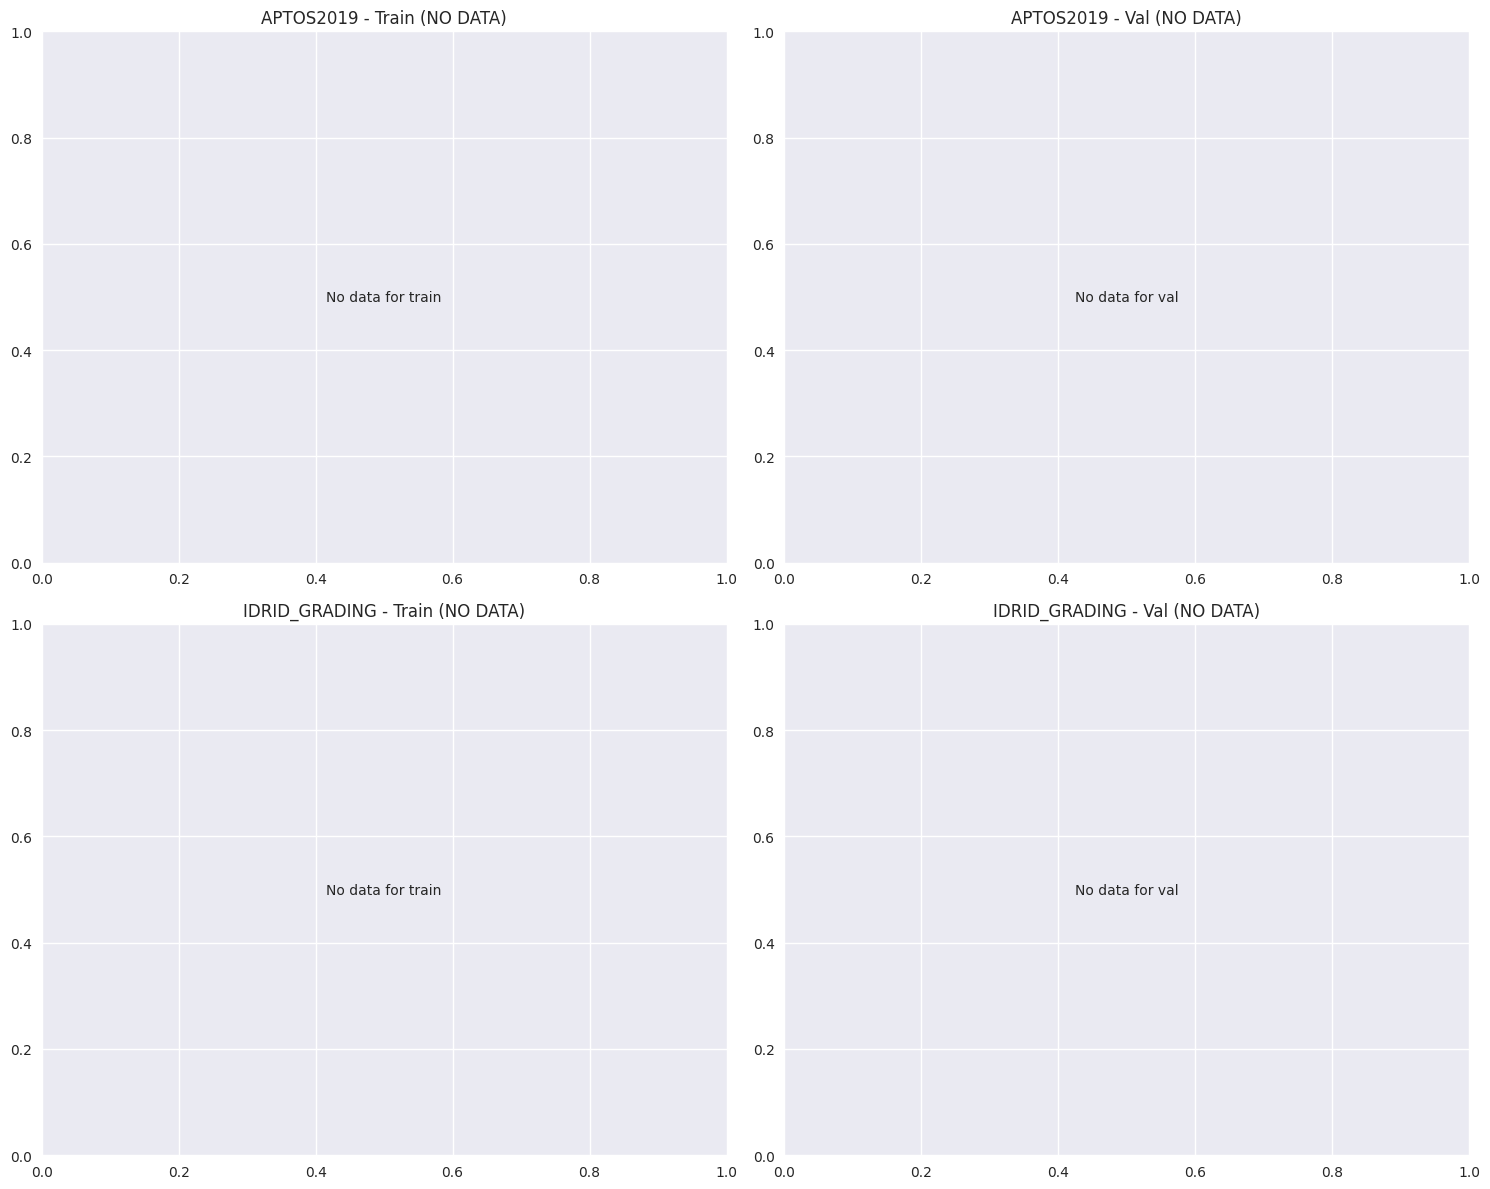

\nCLASS DISTRIBUTION SUMMARY STATISTICS
No distribution data available for summary statistics.


In [5]:
# Create comprehensive distribution visualizations
def plot_class_distributions(balance_results):
    """Create publication-quality distribution plots."""
    
    # Classification datasets
    classification_datasets = [name for name in balance_results.keys() 
                             if 'segmentation' not in name]
    
    if classification_datasets:
        n_datasets = len(classification_datasets)
        fig, axes = plt.subplots(n_datasets, 2, figsize=(15, 6*n_datasets))
        
        if n_datasets == 1:
            axes = axes.reshape(1, -1)
        
        for idx, dataset_name in enumerate(classification_datasets):
            results = balance_results[dataset_name]
            
            # Prepare data for plotting
            splits = ['train', 'val']
            split_data = {}
            
            for split in splits:
                if split in results and 'distribution' in results[split]:
                    split_data[split] = results[split]['distribution']
            
            # Plot for each split
            for split_idx, split_name in enumerate(splits):
                ax = axes[idx, split_idx] if n_datasets > 1 else axes[split_idx]
                
                if split_name in split_data:
                    data = split_data[split_name]
                    
                    # Create bar plot
                    classes = list(data.keys())
                    counts = list(data.values())
                    
                    bars = ax.bar(classes, counts, alpha=0.7, edgecolor='black')
                    
                    # Add value labels on bars
                    for bar, count in zip(bars, counts):
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                               f'{count}', ha='center', va='bottom', fontweight='bold')
                    
                    ax.set_title(f'{dataset_name.upper()} - {split_name.capitalize()} Split\\n'
                               f'Total: {sum(counts)} images', fontsize=12, fontweight='bold')
                    ax.set_xlabel('DR Grade', fontsize=11)
                    ax.set_ylabel('Number of Images', fontsize=11)
                    ax.grid(True, alpha=0.3)
                    
                    # Calculate and display statistics
                    total = sum(counts)
                    proportions = [c/total for c in counts]
                    entropy = -sum(p * np.log2(p) if p > 0 else 0 for p in proportions)
                    
                    # Add statistics text box
                    stats_text = f'Entropy: {entropy:.2f}\\nMost frequent: {max(counts)}'
                    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
                           verticalalignment='top', fontsize=9)
                else:
                    ax.text(0.5, 0.5, f'No data for {split_name}', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{dataset_name.upper()} - {split_name.capitalize()} (NO DATA)')
        
        plt.tight_layout()
        plt.show()

# Generate distribution plots
plot_class_distributions(balance_results)

# Create summary statistics table
print("\\nCLASS DISTRIBUTION SUMMARY STATISTICS")
print("="*60)

summary_stats = []
for dataset_name, results in balance_results.items():
    for split_name, split_data in results.items():
        if isinstance(split_data, dict) and 'distribution' in split_data:
            dist = split_data['distribution']
            total = split_data['total']
            
            if dist:
                counts = list(dist.values())
                classes = list(dist.keys())
                
                stats = {
                    'Dataset': dataset_name,
                    'Split': split_name,
                    'Total_Images': total,
                    'Num_Classes': len(classes),
                    'Min_Count': min(counts),
                    'Max_Count': max(counts),
                    'Mean_Count': np.mean(counts),
                    'Std_Count': np.std(counts),
                    'Imbalance_Ratio': max(counts) / min(counts) if min(counts) > 0 else np.inf
                }
                summary_stats.append(stats)

if summary_stats:
    stats_df = pd.DataFrame(summary_stats)
    print(stats_df.to_string(index=False, float_format='%.2f'))
else:
    print("No distribution data available for summary statistics.")

## 5. Corrupted or Bad Data Detection

Comprehensive integrity tests including image readability checks, mask validation, file naming consistency, and format validation.

In [7]:
# Run comprehensive data integrity checks
print("RUNNING DATA INTEGRITY CHECKS")
print("="*60)

integrity_results = quality_assessor.check_data_integrity(split_data)

# Display detailed integrity results
print("\nINTEGRITY CHECK RESULTS:")
print("-" * 40)

for dataset_name, results in integrity_results.items():
    print(f"\n{dataset_name.upper()}:")
    
    # Overall statistics
    total_files = results.get('total_files_checked', 0)
    readable_files = results.get('readable_files', 0)
    corrupted_files = results.get('corrupted_files', [])
    missing_files = results.get('missing_files', [])
    
    print(f"  Total Files Checked: {total_files}")
    print(f"  Readable Files: {readable_files}")
    print(f"  Success Rate: {(readable_files/total_files*100) if total_files > 0 else 0:.1f}%")
    
    # File issues
    if corrupted_files:
        print(f"  Corrupted Files ({len(corrupted_files)}):")
        for file_path in corrupted_files[:5]:  # Show first 5
            print(f"    - {file_path}")
        if len(corrupted_files) > 5:
            print(f"    ... and {len(corrupted_files) - 5} more")
    
    if missing_files:
        print(f"  Missing Files ({len(missing_files)}):")
        for file_path in missing_files[:5]:  # Show first 5
            print(f"    - {file_path}")
        if len(missing_files) > 5:
            print(f"    ... and {len(missing_files) - 5} more")
    
    # Format validation
    if 'format_validation' in results:
        format_results = results['format_validation']
        print(f"  Format Validation:")
        for format_type, count in format_results.items():
            print(f"    {format_type}: {count} files")
    
    # Size statistics
    if 'size_statistics' in results:
        size_stats = results['size_statistics']
        print(f"  Size Statistics:")
        print(f"    Mean: {size_stats.get('mean', 0):.0f} bytes")
        print(f"    Min: {size_stats.get('min', 0):,} bytes")
        print(f"    Max: {size_stats.get('max', 0):,} bytes")
        
        # Check for suspiciously small files
        if size_stats.get('min', 0) < 1000:  # Less than 1KB
            print(f"    Warning: Very small files detected (min: {size_stats.get('min', 0)} bytes)")
    
    # Segmentation-specific checks
    if 'mask_validation' in results:
        mask_results = results['mask_validation']
        print(f"  Mask Validation:")
        print(f"    Valid Masks: {mask_results.get('valid_masks', 0)}")
        print(f"    Invalid Masks: {mask_results.get('invalid_masks', 0)}")
        
        if mask_results.get('mismatched_pairs', []):
            mismatched = mask_results['mismatched_pairs']
            print(f"    Mismatched Image-Mask Pairs ({len(mismatched)}):")
            for pair in mismatched[:3]:  # Show first 3
                print(f"      - {pair}")

# Create integrity summary visualization
def plot_integrity_summary(integrity_results):
    """Create visualization of integrity check results."""
    
    datasets = list(integrity_results.keys())
    if not datasets:
        print("No integrity data to visualize.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Success rates
    success_rates = []
    corruption_counts = []
    missing_counts = []
    
    for dataset in datasets:
        results = integrity_results[dataset]
        total = results.get('total_files_checked', 0)
        readable = results.get('readable_files', 0)
        
        success_rate = (readable / total * 100) if total > 0 else 0
        success_rates.append(success_rate)
        
        corruption_counts.append(len(results.get('corrupted_files', [])))
        missing_counts.append(len(results.get('missing_files', [])))
    
    # Plot 1: Success rates
    bars1 = ax1.bar(datasets, success_rates, alpha=0.7, color='green', edgecolor='black')
    ax1.set_title('File Integrity Success Rates', fontweight='bold')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_ylim(0, 105)
    ax1.grid(True, alpha=0.3)
    
    # Add percentage labels
    for bar, rate in zip(bars1, success_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Problem counts
    x = np.arange(len(datasets))
    width = 0.35
    
    bars2 = ax2.bar(x - width/2, corruption_counts, width, label='Corrupted', 
                    color='red', alpha=0.7, edgecolor='black')
    bars3 = ax2.bar(x + width/2, missing_counts, width, label='Missing', 
                    color='orange', alpha=0.7, edgecolor='black')
    
    ax2.set_title('File Problems by Dataset', fontweight='bold')
    ax2.set_ylabel('Number of Files')
    ax2.set_xticks(x)
    ax2.set_xticklabels(datasets)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add count labels
    for bars in [bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

plot_integrity_summary(integrity_results)

print("\nData integrity check completed!")
print("="*60)

RUNNING DATA INTEGRITY CHECKS

Running data integrity checks...


AttributeError: 'float' object has no attribute 'items'

## 6. Immutable Split Documentation Export

Exporting final train/validation image lists as CSV files with metadata for exact experiment reproducibility.

In [ ]:
# Create immutable split documentation
print("CREATING IMMUTABLE SPLIT DOCUMENTATION")
print("="*60)

documentation_results = quality_assessor.create_immutable_split_documentation()

# Display documentation results
print("\\nDOCUMENTATION EXPORT RESULTS:")
print("-" * 40)

for dataset_name, results in documentation_results.items():
    print(f"\\n{dataset_name.upper()}:")
    
    if 'csv_files' in results:
        csv_files = results['csv_files']
        print(f"  CSV Files Created: {len(csv_files)}")
        for csv_file in csv_files:
            print(f"    - {csv_file}")
    
    if 'metadata' in results:
        metadata = results['metadata']
        print(f"  Metadata:")
        print(f"    Creation Date: {metadata.get('creation_date', 'N/A')}")
        print(f"    Total Images: {metadata.get('total_images', 0)}")
        print(f"    Train Images: {metadata.get('train_count', 0)}")
        print(f"    Val Images: {metadata.get('val_count', 0)}")
        print(f"    Data Hash: {metadata.get('data_hash', 'N/A')[:16]}...")
    
    if 'split_checksums' in results:
        checksums = results['split_checksums']
        print(f"  Split Checksums:")
        for split_name, checksum in checksums.items():
            print(f"    {split_name}: {checksum[:16]}...")

# Load and display sample of exported CSV data
print("\\nSAMPLE EXPORTED DATA:")
print("-" * 40)

results_dir = project_root / "results" / "immutable_splits"
if results_dir.exists():
    csv_files = list(results_dir.glob("*.csv"))
    
    for csv_file in csv_files[:2]:  # Show first 2 CSV files
        try:
            df = pd.read_csv(csv_file)
            print(f"\\n{csv_file.name}:")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            
            # Show first few rows
            if len(df) > 0:
                print("  Sample data:")
                print(df.head(3).to_string(index=False))
            
        except Exception as e:
            print(f"\\n{csv_file.name}: Error reading file - {e}")
else:
    print("No exported CSV files found.")

# Verify file integrity of exports
print("\\nVERIFYING EXPORT INTEGRITY:")
print("-" * 30)

total_exported_images = 0
for dataset_name, split_data in split_data.items():
    if 'splits' in split_data:
        dataset_total = sum(len(imgs) for imgs in split_data['splits'].values())
        total_exported_images += dataset_total
        print(f"{dataset_name}: {dataset_total} images")

print(f"\\nTotal Images in Exports: {total_exported_images}")
print("Export integrity verification completed!")
print("="*60)

## 7. Visual Quality Spot-Checks

Random sampling and visualization of image-label pairs and image-mask overlays to verify spatial accuracy and label correctness.

In [ ]:
# Initialize visual quality checker and run all checks
visual_checker = VisualQualityChecker(project_root)

print("RUNNING VISUAL QUALITY SPOT-CHECKS")
print("="*60)

# Run all visual quality checks
visual_checker.run_all_visual_checks()

# Display the generated visual check files
visual_check_dir = project_root / "results" / "visual_quality_checks"
if visual_check_dir.exists():
    generated_files = list(visual_check_dir.glob("*.png"))
    
    print(f"\\nGenerated Visual Check Files: {len(generated_files)}")
    print("-" * 40)
    
    for file_path in generated_files:
        file_size = file_path.stat().st_size / 1024  # KB
        print(f"  - {file_path.name} ({file_size:.1f} KB)")
    
    # Display some of the visual checks inline if possible
    print("\\nSample Visual Quality Checks:")
    print("-" * 30)
    
    # Note: In a real notebook environment, you could display images with:
    # from IPython.display import Image, display
    # for img_file in generated_files[:2]:
    #     display(Image(str(img_file)))
    
    print("Visual check images have been saved and can be reviewed manually.")
    print("These images provide spot-checks for:")
    print("  • Image quality and consistency across splits")
    print("  • Proper image-mask alignment for segmentation data")
    print("  • Detection of corruption or artifacts")
    print("  • Verification of preprocessing results")
    
else:
    print("No visual check files found.")

# Create a quick inline visualization of some sampled data
def create_inline_sample_check():
    """Create a simple inline quality check visualization."""
    
    # Sample some images for quick verification
    aptos_samples = visual_checker.sample_images_from_split('aptos2019', 'train', 2)
    
    if aptos_samples:
        print(f"\\nQuick Sample Check - APTOS 2019 Train Split:")
        print(f"Sampled Images: {aptos_samples}")
        
        images_dir = project_root / "dataset" / "processed" / "aptos2019" / "images"
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('APTOS 2019 - Sample Image Quality Check', fontweight='bold')
        
        for idx, img_id in enumerate(aptos_samples):
            ax = axes[idx]
            img_path = images_dir / f"{img_id}.jpg"
            
            if img_path.exists():
                try:
                    img = cv2.imread(str(img_path))
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    ax.imshow(img_rgb)
                    ax.set_title(f'Image: {img_id}\\nShape: {img_rgb.shape}')
                    ax.axis('off')
                    
                    # Add basic statistics
                    mean_val = np.mean(img_rgb)
                    std_val = np.std(img_rgb)
                    ax.text(0.02, 0.98, f'Mean: {mean_val:.1f}\\nStd: {std_val:.1f}', 
                           transform=ax.transAxes, 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                           fontsize=10, verticalalignment='top')
                           
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading\\n{img_id}\\n{str(e)}', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'Image: {img_id} (ERROR)')
            else:
                ax.text(0.5, 0.5, f'File not found:\\n{img_id}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'Image: {img_id} (MISSING)')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No APTOS samples available for inline check.")

create_inline_sample_check()

print("\\nVisual quality spot-checks completed!")
print("="*60)

## 8. Data Integrity Overlap and Leakage Control

Detecting and resolving image overlaps between datasets and ensuring no data leakage between train/validation splits.

In [ ]:
# Run data leakage detection
print("RUNNING DATA LEAKAGE DETECTION")
print("="*60)

leakage_results = quality_assessor.detect_data_leakage()

# Display leakage detection results
print("\\nLEAKAGE DETECTION RESULTS:")
print("-" * 40)

overall_leakage_found = False

for dataset_name, results in leakage_results.items():
    print(f"\\n{dataset_name.upper()}:")
    
    # Train-Val leakage within dataset
    if 'within_dataset_leakage' in results:
        within_leakage = results['within_dataset_leakage']
        overlap_count = len(within_leakage.get('overlapping_images', []))
        
        if overlap_count > 0:
            print(f"  ❌ Train-Val Leakage: {overlap_count} overlapping images")
            overall_leakage_found = True
            
            # Show some examples
            overlapping = within_leakage['overlapping_images'][:5]
            for img_id in overlapping:
                print(f"    - {img_id}")
            if len(within_leakage.get('overlapping_images', [])) > 5:
                remaining = len(within_leakage['overlapping_images']) - 5
                print(f"    ... and {remaining} more")
        else:
            print(f"  ✅ Train-Val Leakage: None detected")
    
    # Cross-dataset overlaps
    if 'cross_dataset_overlaps' in results:
        cross_overlaps = results['cross_dataset_overlaps']
        
        if cross_overlaps:
            print(f"  Cross-Dataset Overlaps:")
            for other_dataset, overlap_data in cross_overlaps.items():
                overlap_count = len(overlap_data.get('common_images', []))
                if overlap_count > 0:
                    print(f"    with {other_dataset}: {overlap_count} common images")
                    overall_leakage_found = True
                    
                    # Show potential leakage scenarios
                    common_imgs = overlap_data.get('common_images', [])[:3]
                    for img_id in common_imgs:
                        print(f"      - {img_id}")
        else:
            print(f"  ✅ Cross-Dataset Overlaps: None detected")
    
    # Summary statistics
    if 'summary' in results:
        summary = results['summary']
        print(f"  Summary:")
        print(f"    Train Images: {summary.get('train_count', 0)}")
        print(f"    Val Images: {summary.get('val_count', 0)}")
        print(f"    Unique Images: {summary.get('unique_images', 0)}")
        print(f"    Isolation Score: {summary.get('isolation_score', 0):.3f}")

# Create leakage summary visualization
def plot_leakage_summary(leakage_results):
    """Visualize leakage detection results."""
    
    datasets = list(leakage_results.keys())
    if not datasets:
        return
    
    # Collect leakage statistics
    within_leakage_counts = []
    isolation_scores = []
    
    for dataset in datasets:
        results = leakage_results[dataset]
        
        # Within-dataset leakage
        within_leakage = results.get('within_dataset_leakage', {})
        leakage_count = len(within_leakage.get('overlapping_images', []))
        within_leakage_counts.append(leakage_count)
        
        # Isolation score
        summary = results.get('summary', {})
        isolation_score = summary.get('isolation_score', 1.0)
        isolation_scores.append(isolation_score)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Leakage counts
    colors = ['red' if count > 0 else 'green' for count in within_leakage_counts]
    bars1 = ax1.bar(datasets, within_leakage_counts, color=colors, alpha=0.7, edgecolor='black')
    
    ax1.set_title('Train-Validation Leakage Detection', fontweight='bold')
    ax1.set_ylabel('Number of Overlapping Images')
    ax1.grid(True, alpha=0.3)
    
    # Add count labels
    for bar, count in zip(bars1, within_leakage_counts):
        height = bar.get_height()
        status = "❌ LEAKAGE" if count > 0 else "✅ CLEAN"
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(within_leakage_counts)*0.02,
                f'{count}\\n{status}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Isolation scores
    colors2 = ['red' if score < 1.0 else 'green' for score in isolation_scores]
    bars2 = ax2.bar(datasets, isolation_scores, color=colors2, alpha=0.7, edgecolor='black')
    
    ax2.set_title('Dataset Isolation Scores', fontweight='bold')
    ax2.set_ylabel('Isolation Score (1.0 = Perfect)')
    ax2.set_ylim(0, 1.1)
    ax2.grid(True, alpha=0.3)
    
    # Add score labels
    for bar, score in zip(bars2, isolation_scores):
        height = bar.get_height()
        status = "ISOLATED" if score >= 1.0 else "OVERLAP"
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.3f}\\n{status}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_leakage_summary(leakage_results)

# Overall leakage assessment
print("\\nOVERALL LEAKAGE ASSESSMENT:")
print("-" * 30)

if overall_leakage_found:
    print("❌ DATA LEAKAGE DETECTED!")
    print("   Action required: Review and resolve overlapping images")
    print("   This could compromise model evaluation integrity")
else:
    print("✅ NO DATA LEAKAGE DETECTED")
    print("   All datasets maintain proper train-validation isolation")

print("\\nLeakage detection completed!")
print("="*60)

## 9. Transparent Reporting Dashboard

Comprehensive summary report with all quality metrics, warnings, errors, and visual evidence compiled for documentation.

In [ ]:
# Generate comprehensive quality assessment report
print("GENERATING COMPREHENSIVE QUALITY ASSESSMENT REPORT")
print("="*70)

# Compile all results for comprehensive reporting
def generate_comprehensive_report():
    """Generate a complete quality assessment report."""
    
    report = {
        'assessment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'datasets_analyzed': list(split_data.keys()),
        'phase': '2.3 - Data Quality Assessment',
        'summary_metrics': {},
        'issues_found': [],
        'recommendations': []
    }
    
    # Aggregate metrics from all analyses
    total_images = 0
    total_datasets = len(split_data)
    issues_detected = 0
    
    # Summary from split data
    for dataset_name, data in split_data.items():
        total_images += data.get('total_images', 0)
    
    # Summary from integrity results
    total_files_checked = 0
    total_corrupted = 0
    total_missing = 0
    
    for dataset_name, results in integrity_results.items():
        total_files_checked += results.get('total_files_checked', 0)
        total_corrupted += len(results.get('corrupted_files', []))
        total_missing += len(results.get('missing_files', []))
    
    # Summary from leakage results
    total_leakage_issues = 0
    for dataset_name, results in leakage_results.items():
        within_leakage = results.get('within_dataset_leakage', {})
        leakage_count = len(within_leakage.get('overlapping_images', []))
        total_leakage_issues += leakage_count
    
    # Compile summary metrics
    report['summary_metrics'] = {
        'total_datasets': total_datasets,
        'total_images': total_images,
        'total_files_checked': total_files_checked,
        'integrity_success_rate': ((total_files_checked - total_corrupted - total_missing) / total_files_checked * 100) if total_files_checked > 0 else 0,
        'corrupted_files': total_corrupted,
        'missing_files': total_missing,
        'leakage_issues': total_leakage_issues
    }
    
    # Identify issues
    if total_corrupted > 0:
        report['issues_found'].append(f"Data corruption detected: {total_corrupted} corrupted files")
        issues_detected += 1
    
    if total_missing > 0:
        report['issues_found'].append(f"Missing files detected: {total_missing} missing files")
        issues_detected += 1
    
    if total_leakage_issues > 0:
        report['issues_found'].append(f"Data leakage detected: {total_leakage_issues} overlapping images")
        issues_detected += 1
    
    # Check for class imbalance issues
    for dataset_name, results in balance_results.items():
        for split_name, split_data in results.items():
            if isinstance(split_data, dict) and 'distribution' in split_data:
                dist = split_data['distribution']
                if dist:
                    counts = list(dist.values())
                    min_count = min(counts)
                    max_count = max(counts)
                    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
                    
                    if imbalance_ratio > 10:
                        report['issues_found'].append(f"Severe class imbalance in {dataset_name} {split_name}: ratio {imbalance_ratio:.1f}")
                        issues_detected += 1
    
    # Generate recommendations
    if issues_detected == 0:
        report['recommendations'].append("✅ Data quality is excellent - ready for model training")
        report['recommendations'].append("All integrity checks passed successfully")
        report['recommendations'].append("No data leakage detected between splits")
    else:
        if total_corrupted > 0:
            report['recommendations'].append("🔧 Resolve corrupted files before training")
        if total_missing > 0:
            report['recommendations'].append("🔧 Investigate and restore missing files")
        if total_leakage_issues > 0:
            report['recommendations'].append("🔧 Critical: Remove overlapping images to prevent data leakage")
        
        report['recommendations'].append("Re-run quality assessment after fixes")
    
    report['overall_status'] = 'PASS' if issues_detected == 0 else 'FAIL'
    report['issues_count'] = issues_detected
    
    return report

# Generate the comprehensive report
final_report = generate_comprehensive_report()

# Display the comprehensive report
print("\\n" + "="*70)
print("           PHASE 2.3 DATA QUALITY ASSESSMENT REPORT")
print("="*70)

print(f"Assessment Date: {final_report['assessment_date']}")
print(f"Phase: {final_report['phase']}")
print(f"Overall Status: {final_report['overall_status']}")

print(f"\\n📊 SUMMARY METRICS:")
print("-" * 50)
metrics = final_report['summary_metrics']
print(f"Total Datasets Analyzed: {metrics['total_datasets']}")
print(f"Total Images Processed: {metrics['total_images']:,}")
print(f"Files Integrity Checked: {metrics['total_files_checked']:,}")
print(f"Integrity Success Rate: {metrics['integrity_success_rate']:.1f}%")
print(f"Corrupted Files: {metrics['corrupted_files']}")
print(f"Missing Files: {metrics['missing_files']}")
print(f"Data Leakage Issues: {metrics['leakage_issues']}")

if final_report['issues_found']:
    print(f"\\n⚠️  ISSUES DETECTED ({final_report['issues_count']}):")
    print("-" * 50)
    for i, issue in enumerate(final_report['issues_found'], 1):
        print(f"{i}. {issue}")
else:
    print(f"\\n✅ NO ISSUES DETECTED")
    print("-" * 50)
    print("All quality checks passed successfully!")

print(f"\\n💡 RECOMMENDATIONS:")
print("-" * 50)
for i, recommendation in enumerate(final_report['recommendations'], 1):
    print(f"{i}. {recommendation}")

# Dataset-specific summary table
print(f"\\n📋 DATASET-SPECIFIC SUMMARY:")
print("-" * 50)

dataset_summary = []
for dataset_name in final_report['datasets_analyzed']:
    # Get split counts
    split_counts = {}
    if dataset_name in split_data and 'splits' in split_data[dataset_name]:
        for split_name, imgs in split_data[dataset_name]['splits'].items():
            split_counts[split_name] = len(imgs)
    
    # Get integrity status
    integrity_status = "✅"
    if dataset_name in integrity_results:
        results = integrity_results[dataset_name]
        corrupted = len(results.get('corrupted_files', []))
        missing = len(results.get('missing_files', []))
        if corrupted > 0 or missing > 0:
            integrity_status = "❌"
    
    # Get leakage status
    leakage_status = "✅"
    if dataset_name in leakage_results:
        results = leakage_results[dataset_name]
        within_leakage = results.get('within_dataset_leakage', {})
        if len(within_leakage.get('overlapping_images', [])) > 0:
            leakage_status = "❌"
    
    dataset_summary.append({
        'Dataset': dataset_name,
        'Train': split_counts.get('train', 0),
        'Val': split_counts.get('val', 0),
        'Total': sum(split_counts.values()),
        'Integrity': integrity_status,
        'Leakage': leakage_status
    })

if dataset_summary:
    summary_df = pd.DataFrame(dataset_summary)
    print(summary_df.to_string(index=False))

# Export report to JSON for reproducibility
report_path = project_root / "results" / "quality_assessment_report.json"
report_path.parent.mkdir(parents=True, exist_ok=True)

with open(report_path, 'w') as f:
    json.dump(final_report, f, indent=2)

print(f"\\n💾 REPORT EXPORTED:")
print(f"Report saved to: {report_path}")

print(f"\\n🎯 NEXT STEPS:")
print("-" * 50)

if final_report['overall_status'] == 'PASS':
    print("1. ✅ Data quality assessment PASSED")
    print("2. 🚀 Ready to proceed to Phase 3: Model Development")
    print("3. 📚 Use exported CSV files for reproducible training")
    print("4. 📊 Reference visual quality checks for documentation")
else:
    print("1. 🔧 Address identified issues before proceeding")
    print("2. 🔄 Re-run quality assessment after fixes")
    print("3. ⏸️  Hold Phase 3 until all issues resolved")

print("\\n" + "="*70)
print("           PHASE 2.3 ASSESSMENT COMPLETED")
print("="*70)